# **Introduction**

Agriculture remains one of the most vital sectors globally, directly influencing food security, livelihoods, and economic growth — particularly in developing regions. However, plant diseases continue to threaten crop yields and farmer income, often spreading rapidly due to delayed diagnosis and limited access to expert agronomists.


This project explores the PlantVillage dataset, a well-known open-source collection of plant leaf images used for automated plant disease detection. The dataset provides labeled examples of both healthy and diseased leaves across multiple plant species, making it suitable for developing and comparing machine learning (ML) and deep learning (DL) models.

The motivation for this work stems from its direct connection to my Agrilink project, a mobile and web-based platform designed to support farmers through data-driven insights. One of Agrilink’s core features, the Plant Doctor, aims to provide farmers with real-time, AI-powered disease diagnosis using captured leaf images. By experimenting with classical ML algorithms and modern convolutional neural networks (CNNs) on the PlantVillage dataset, this study seeks to identify approaches that can later be adapted and integrated into the Plant Doctor module.

Beyond model performance, this work focuses on understanding data patterns, classification challenges, and the practical trade-offs between traditional ML and transfer learning approaches. The ultimate goal is to contribute toward a scalable, interpretable, and reliable disease diagnosis system that empowers farmers with early detection and actionable recommendations.

# **Project Objectives**

The primary objectives of this project are:

1. Develop a robust dataset understanding by performing exploratory data analysis (EDA) on PlantVillage images to identify class distributions, variability, and potential data quality issues.

2. Implement and compare machine learning and deep learning models for plant disease classification, including classical ML algorithms and convolutional neural networks (CNNs) with transfer learning.

3. Evaluate model performance using metrics such as accuracy, F1-score, and AUC-ROC to identify strengths, weaknesses, and potential biases.

4. Analyze errors and limitations to understand misclassifications, overfitting/underfitting issues, and challenges inherent in the dataset.

5. Lay the foundation for the Plant Doctor module in the Agrilink project by identifying models and preprocessing steps that can be practically integrated into a real-world application.

In [6]:
# 1. Setup
!pip install "numpy<2.0" "pandas<2.3" "scikit-learn==1.3.1" "matplotlib" "seaborn" "opencv-python" --upgrade
# !pip install --upgrade "numpy<2.0" "scikit-learn" pandas scipy matplotlib seaborn

import os
import random
import json
import shutil
import math
import time
from pathlib import Path
from datetime import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
TensorFlow version: 2.18.0


## Data loading

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [3]:
os.makedirs("./data", exist_ok=True)
try:
  shutil.move(path, "./data")
except Exception as e:
  print(e)


[Errno 30] Read-only file system: '0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG'


In [11]:
import tensorflow as tf
import h5py
import json

# First, let's try loading with legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Method 1: Try with tf.keras directly and custom handling
model_path = '/kaggle/input/plantvillage/tensorflow2/default/1/plant_disease_resnet50_checkpoint_01.h5'

# Load just the weights and recreate the model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Check the model structure first
with h5py.File(model_path, 'r') as f:
    if 'model_config' in f.attrs:
        config = f.attrs['model_config']
        if isinstance(config, bytes):
            config = config.decode('utf-8')
        print("Model config found")
        print(config[:500] if len(config) > 500 else config)

Model config found
{"class_name": "Functional", "config": {"name": "functional_1", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_shape": [null, 190, 190, 3], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "name": "input_layer_1", "inbound_nodes": []}, {"class_name": "Lambda", "config": {"name": "lambda", "trainable": false, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "function": {"class_name": "__l


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import h5py

model_path = '/kaggle/input/plantvillage/tensorflow2/default/1/plant_disease_resnet50_checkpoint_01.h5'

# First find the number of output classes
with h5py.File(model_path, 'r') as f:
    def find_output_shape(name, obj):
        if isinstance(obj, h5py.Dataset) and 'kernel' in name:
            if 'dense' in name.lower() or 'predictions' in name.lower():
                print(f"{name}: shape={obj.shape}")
    f.visititems(find_output_shape)

model_weights/dense_2/dense_2/kernel: shape=(2048, 256)
model_weights/dense_3/dense_3/kernel: shape=(256, 15)
optimizer_weights/adam/dense_2_kernel_momentum: shape=(2048, 256)
optimizer_weights/adam/dense_2_kernel_velocity: shape=(2048, 256)
optimizer_weights/adam/dense_3_kernel_momentum: shape=(256, 15)
optimizer_weights/adam/dense_3_kernel_velocity: shape=(256, 15)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import h5py

model_path = '/kaggle/input/plantvillage/tensorflow2/default/1/plant_disease_resnet50_checkpoint_01.h5'

# Recreate the EXACT architecture: 190x190 input, Lambda preprocessing, ResNet50
inputs = layers.Input(shape=(190, 190, 3))

# Lambda layer for preprocessing (ResNet50 preprocess_input)
x = layers.Lambda(lambda img: tf.keras.applications.resnet50.preprocess_input(img))(inputs)

# ResNet50 base
base_model = ResNet50(weights=None, include_top=False, input_shape=(190, 190, 3))
x = base_model(x)

# Top layers - check output from previous cell for exact Dense sizes
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation='softmax')(x)  # Adjust if different

model = models.Model(inputs=inputs, outputs=outputs)

# Load weights
model.load_weights(model_path, by_name=True, skip_mismatch=True)
print("Weights loaded!")

# Save in new compatible format
model.save('plant_disease_model.keras')
print("Saved as plant_disease_model.keras - download this file!")

I0000 00:00:1764257651.951530      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Weights loaded!
Saved as plant_disease_model.keras - download this file!


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Build model WITHOUT Lambda layer (we'll handle preprocessing in the API)
inputs = layers.Input(shape=(190, 190, 3), name='input_layer')

# ResNet50 base - load pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(190, 190, 3))

x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.5, name='dropout')(x)
outputs = layers.Dense(15, activation='softmax', name='predictions')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Now load your trained weights
old_model_path = '/kaggle/input/plantvillage/tensorflow2/default/1/plant_disease_resnet50_checkpoint_01.h5'

# Try loading weights
try:
    model.load_weights(old_model_path, by_name=True, skip_mismatch=True)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error: {e}")

# Save in new format (without Lambda layer)
model.save('plant_disease_model_v2.keras')
print("Model saved as plant_disease_model_v2.keras")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!
Model saved as plant_disease_model_v2.keras
Input shape: (None, 190, 190, 3)
Output shape: (None, 15)


## Data Preprocessing

In [4]:
# Let's check for any corrupted images
from PIL import UnidentifiedImageError, Image

data_dir = "./data/plantdisease/PlantVillage"
classes = os.listdir(data_dir) # list all class names

bad_images = []

for cls in classes:
  cls_dir = os.path.join(data_dir,cls)
  if os.path.isdir(cls_dir):
    for img_name in os.listdir(cls_dir):
      img_path = os.path.join(cls_dir,img_name)
      try:
        img = Image.open(img_path)
        img.verify()
      except UnidentifiedImageError:
        bad_images.append(img_path)

print("Number of corrupted images:", len(bad_images))
print(bad_images)

Number of corrupted images: 1
['./data/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c']


We have one corrupted image Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c and we are going to delete it from our dataset.

In [5]:
# Let's remove the corrupted image
for image in bad_images:
  os.remove(image)

In [6]:
shutil.rmtree('./data/plantdisease/plantvillage')

Count the number of classes in our dataset and create a pandas dataframe that will be used to draw some insight about our data. We are going to use the dataframe to count the number of images we have per class.

In [7]:

print("Found classes:", len(classes))

# Define common image extensions to look for
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

data_info = []

for cls in classes:
  cls_dir = os.path.join(data_dir, cls)
  
  if os.path.isdir(cls_dir):
    # Use a list comprehension to count only files with valid image extensions
    # file.lower() makes the check case-insensitive (e.g., catches .JPG and .jpg)
    n_images = len([file for file in os.listdir(cls_dir) 
                    if file.lower().endswith(image_extensions)])
    
    data_info.append((cls, n_images))

# Create the DataFrame and display it
df = pd.DataFrame(data_info, columns=["Class", "Image Count"])
df = df.sort_values(by="Class").reset_index(drop=True)
print(df.head(15))

Found classes: 15
                                          Class  Image Count
0                 Pepper__bell___Bacterial_spot          997
1                        Pepper__bell___healthy         1478
2                         Potato___Early_blight         1000
3                          Potato___Late_blight         1000
4                              Potato___healthy          152
5                         Tomato_Bacterial_spot         2127
6                           Tomato_Early_blight         1000
7                            Tomato_Late_blight         1909
8                              Tomato_Leaf_Mold          952
9                     Tomato_Septoria_leaf_spot         1771
10  Tomato_Spider_mites_Two_spotted_spider_mite         1676
11                          Tomato__Target_Spot         1404
12        Tomato__Tomato_YellowLeaf__Curl_Virus         3208
13                  Tomato__Tomato_mosaic_virus          373
14                               Tomato_healthy         1591


We have 15 classes in our dataset. The number of images per class ranges from only 152 images to 3208 images.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        15 non-null     object
 1   Image Count  15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes


In [10]:
#  total images
df['Image Count'].sum()

20638

Our images count up to 20638, which I would argue is a great number for training a decent model. If we do transfer learning, our model might even be great.

/tmp/ipykernel_38/4223665710.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_38/4223665710.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 5, i+1)


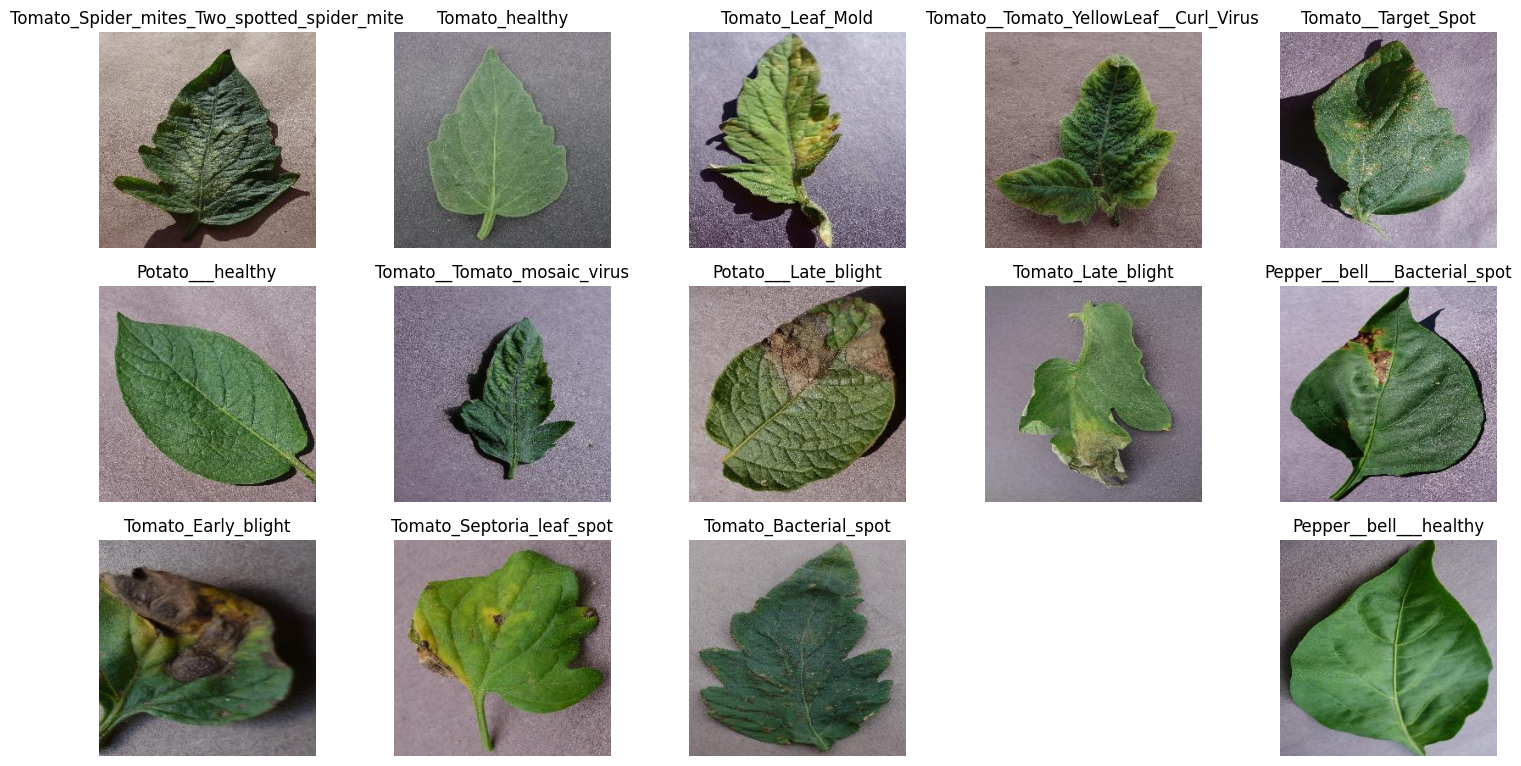

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15, 8))
for i, cls in enumerate(random.sample(classes, 15)):
    cls_path = os.path.join(data_dir, cls)
    img_path = os.path.join(cls_path, random.choice(os.listdir(cls_path)))
    img = mpimg.imread(img_path)
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.tight_layout()
    plt.title(cls)
    plt.axis('off')
plt.show()


## Check image size

In [9]:
from PIL import Image
import numpy as np

sizes = []
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    img = Image.open(img_path)
    sizes.append(img.size)

print(set(sizes))


{(256, 256)}


In [10]:
import cv2
import numpy as np

means, stds = [], []
for cls in classes[:3]:  # sample a few classes
    cls_path = os.path.join(data_dir, cls)
    img_path = os.path.join(cls_path, random.choice(os.listdir(cls_path)))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    means.append(img.mean(axis=(0,1)))
    stds.append(img.std(axis=(0,1)))

print("Mean pixel values (RGB):", np.mean(means, axis=0))
print("Std pixel values (RGB):", np.mean(stds, axis=0))


Mean pixel values (RGB): [117.28967794 117.07168579 106.36387126]
Std pixel values (RGB): [47.79021425 46.78904813 55.28635607]


In [11]:
# Config
DATASET_PATH = data_dir
IMG_SIZE = (190, 190)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Experiment log
EXP_LOG = "experiments_log.csv"
if not os.path.exists(EXP_LOG):
    pd.DataFrame(columns=["exp_id","timestamp","approach","model","variant",
                          "hyperparams","train_time_s","val_acc","val_loss",
                          "notes"]).to_csv(EXP_LOG, index=False)

# Helper to append experiment summary
def log_experiment(row: dict):
    df = pd.read_csv(EXP_LOG)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.to_csv(EXP_LOG, index=False)

## Data Spliting.
We will use scikit-learn to split our dataset into training and validation sets. The reason for not using ``tf.keras.utils.image_dataset_from_directory`` is that our dataset contains some underrepresented classes. Using the Keras utility could result in these minority classes having no images in the validation set, making model evaluation and interpretation unreliable.

In [12]:
DATASET_PATH = data_dir
BATCH_SIZE = 16 # (16,190,190,3)
IMG_SIZE = (190, 190) 
SEED = 42

# Manually gather all file paths and labels
all_filepaths = []
all_labels = []

# Get class names and create a mapping from name to integer
class_names = sorted([name for name in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, name))])
num_classes = len(class_names)
class_to_int = {name: i for i, name in enumerate(class_names)}

for cls_name in class_names:
    class_dir = os.path.join(DATASET_PATH, cls_name)
    for fname in os.listdir(class_dir):
        all_filepaths.append(os.path.join(class_dir, fname))
        all_labels.append(class_to_int[cls_name])

print(f"Found {len(all_filepaths)} images belonging to {num_classes} classes.")

# Perform a stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_filepaths,
    all_labels,
    test_size=0.15,
    random_state=SEED,
    stratify=all_labels
)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

# Create tf.data.Dataset objects from the file paths

# Create a helper function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

# Create the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


print("Verifying Class Distribution in Datasets")
print("Classes:", class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

# Count samples per class in the new validation set
val_class_counts = np.zeros(num_classes, dtype=int)
for _, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[label] += 1

print("Validation set class counts:")
for i, count in enumerate(val_class_counts):
    print(f"  - Class '{class_names[i]}': {count} images")

# Check if any class has zero images
if 0 in val_class_counts:
    print("Warning: A class has 0 images in the validation set!")
else:
    print("Success! All classes are represented in the validation set.")

Found 20638 images belonging to 15 classes.
Training samples: 17542, Validation samples: 3096


I0000 00:00:1764252941.951786      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Verifying Class Distribution in Datasets
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Train batches: 1097 Val batches: 194
Validation set class counts:
  - Class 'Pepper__bell___Bacterial_spot': 149 images
  - Class 'Pepper__bell___healthy': 222 images
  - Class 'Potato___Early_blight': 150 images
  - Class 'Potato___Late_blight': 150 images
  - Class 'Potato___healthy': 23 images
  - Class 'Tomato_Bacterial_spot': 319 images
  - Class 'Tomato_Early_blight': 150 images
  - Class 'Tomato_Late_blight': 286 images
  - Class 'Tomato_Leaf_Mold': 143 images
  - Class 'Tomato_Septoria_leaf_spot': 266 images
  - Class 'Tomato_Sp

### Testing vs validation image count

In [13]:
import numpy as np

def class_counts(ds, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for images, labels in ds.unbatch():
        counts[labels.numpy()] += 1
    return counts

train_counts = class_counts(train_ds, num_classes)
val_counts = class_counts(val_ds, num_classes)

for name, t, v in zip(class_names, train_counts, val_counts):
    print(f"{name}: train={t}, val={v}")


Pepper__bell___Bacterial_spot: train=848, val=149
Pepper__bell___healthy: train=1256, val=222
Potato___Early_blight: train=850, val=150
Potato___Late_blight: train=850, val=150
Potato___healthy: train=129, val=23
Tomato_Bacterial_spot: train=1808, val=319
Tomato_Early_blight: train=850, val=150
Tomato_Late_blight: train=1623, val=286
Tomato_Leaf_Mold: train=809, val=143
Tomato_Septoria_leaf_spot: train=1505, val=266
Tomato_Spider_mites_Two_spotted_spider_mite: train=1425, val=251
Tomato__Target_Spot: train=1193, val=211
Tomato__Tomato_YellowLeaf__Curl_Virus: train=2727, val=481
Tomato__Tomato_mosaic_virus: train=317, val=56
Tomato_healthy: train=1352, val=239


## ****Data Augmentation****

In [14]:
# Data augmentation pipeline (used only for training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds_p = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_p = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Classical ML pipeline (feature extraction + models)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
import tensorflow as tf

def evaluate_model(model, val_ds, class_names, is_dl_model=True):
    """
    Evaluate a model (DL or classical ML) and print + plot metrics.
    Handles class mismatch, missing labels, and empty classes.
    """

    print("Evaluating Model...")

    # Predict depending on model type ---
    if is_dl_model:
        y_true, y_pred = [], []
        for X_batch, y_batch in val_ds:
            preds = model.predict(X_batch, verbose=0)
            y_true.extend(y_batch.numpy())
            y_pred.extend(np.argmax(preds, axis=1))
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    else:
        X_val, y_true = val_ds
        y_pred = model.predict(X_val)
        y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Handle unique classes safely
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    target_names_used = [class_names[i] for i in unique_labels]

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}\n")

    # Classification report
    print("Classification Report:\n")
    print(classification_report(
        y_true, y_pred,
        labels=unique_labels,
        target_names=target_names_used,
        zero_division=0
    ))

    # Step 5: Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_used, yticklabels=target_names_used)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Return metrics dictionary
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm
    }


# Extract arrays for sklearn (small subset to limit memory)

In [16]:
# Convert tf.data to numpy arrays (for classical ML).
def ds_to_numpy(ds, max_samples=None):
    X, y = [], []
    count = 0
    for imgs, labels in ds.unbatch().batch(256):
        arr = imgs.numpy()
        lbl = labels.numpy()
        for a,l in zip(arr, lbl):
            X.append(a)
            y.append(l)
            count += 1
            if max_samples and count >= max_samples:
                return np.array(X), np.array(y)
    return np.array(X), np.array(y)

# full dataset may be large. Here we take up to 4000 samples for sklearn experiments.
X_all, y_all = ds_to_numpy(train_ds, max_samples=4000)  # shape: (N, H, W, 3)
X_flat = X_all.reshape((X_all.shape[0], -1))  # flattened images
print("Class distribution (sample):", pd.Series(y_all).value_counts().sort_index().to_dict())


Class distribution (sample): {0: 190, 1: 270, 2: 196, 3: 209, 4: 32, 5: 397, 6: 193, 7: 359, 8: 180, 9: 355, 10: 320, 11: 266, 12: 624, 13: 73, 14: 336}


# Utilities: compile, callbacks, plotters

In [17]:
def get_callbacks(patience=5, model_name="model"):
    return [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]

def plot_history(history, title):
    h = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(title + " Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.title(title + " Accuracy"); plt.legend()
    plt.show()


Epoch 1/30


I0000 00:00:1764252995.519972     114 service.cc:148] XLA service 0x7f45dc045150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764252995.521106     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764252995.800825     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  16/1097 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.0567 - loss: 11.6304     

I0000 00:00:1764252998.544032     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.2997 - loss: 2.5958 - val_accuracy: 0.5921 - val_loss: 1.2122 - learning_rate: 0.0010
Epoch 2/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5890 - loss: 1.2623 - val_accuracy: 0.7258 - val_loss: 0.8537 - learning_rate: 0.0010
Epoch 3/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6789 - loss: 0.9777 - val_accuracy: 0.7901 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 4/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7284 - loss: 0.8121 - val_accuracy: 0.8553 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 5/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7788 - loss: 0.6704 - val_accuracy: 0.8540 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 6/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8111 - loss: 0.5659 - val_accuracy: 0.8944 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 7/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8360 

/tmp/ipykernel_38/1293992637.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


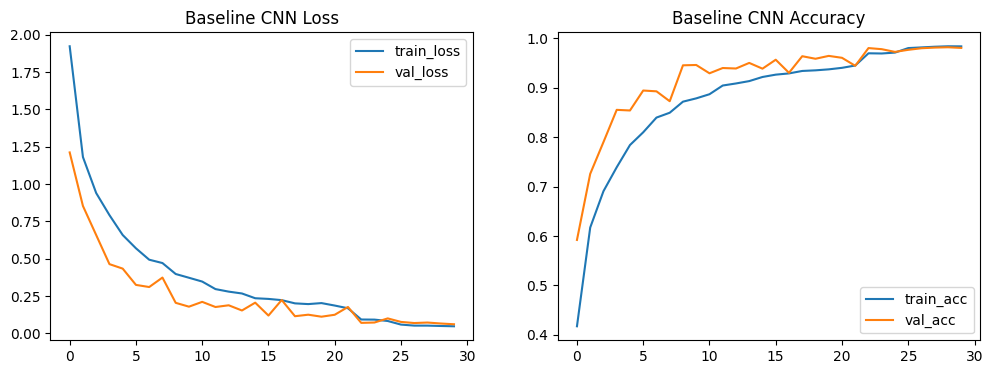

In [18]:

exp_id = "exp_baseline_cnn"
start = time.time()

def make_baseline_cnn(input_shape=(*IMG_SIZE,3), num_classes=num_classes, dropout=0.5):
    model = models.Sequential([
        layers.Input(input_shape),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = make_baseline_cnn()
history_cnn = cnn.fit(train_ds_p, validation_data=val_ds_p, epochs=30, callbacks=get_callbacks(3))
train_time = time.time() - start

# evaluate
val_loss, val_acc = cnn.evaluate(val_ds_p, verbose=0)
print(f"[{exp_id}] val_acc={val_acc:.4f}")

log_experiment({
    "exp_id": exp_id, "timestamp": datetime.utcnow().isoformat(),
    "approach":"deep","model":"BaselineCNN","variant":"sequential_dropout0.5",
    "hyperparams": json.dumps({"lr":1e-3,"dropout":0.5}), "train_time_s": train_time,
    "val_acc": val_acc, "val_loss": val_loss, "notes":"Simple CNN baseline"
})

plot_history(history_cnn, "Baseline CNN")


In [20]:
cnn.save("plant_disease_resnet50_best.h5")

Evaluating Model...
Accuracy:  0.9806
Precision: 0.9808
Recall:    0.9806
F1-score:  0.9806

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.97      0.99       149
                     Pepper__bell___healthy       0.99      1.00      0.99       222
                      Potato___Early_blight       1.00      0.99      0.99       150
                       Potato___Late_blight       0.98      0.99      0.98       150
                           Potato___healthy       0.95      0.91      0.93        23
                      Tomato_Bacterial_spot       0.98      0.99      0.99       319
                        Tomato_Early_blight       0.98      0.94      0.96       150
                         Tomato_Late_blight       0.97      0.98      0.97       286
                           Tomato_Leaf_Mold       0.99      0.98      0.98       143
                  Tomato_Septori

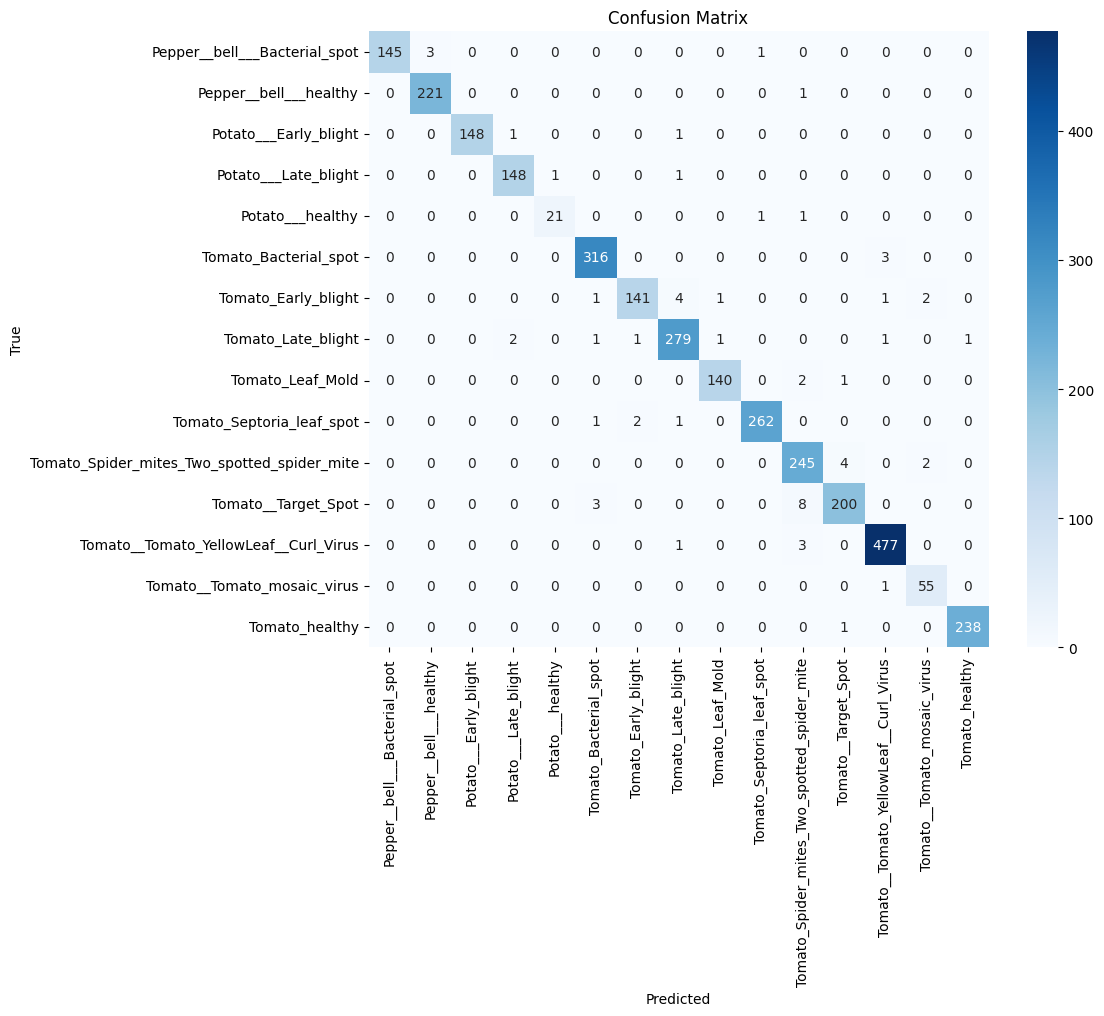

In [21]:
metrics_cnn = evaluate_model(cnn, val_ds_p, class_names, is_dl_model=True)


In [ ]:
# create a feature extractor used for experiment where classical ML uses CNN features
feat_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE,3), pooling='avg')
feat_base.trainable = False

def extract_features_from_ds(ds, model, max_samples=None):
    X_feats, y = [], []
    i = 0
    for images, labels in ds.unbatch().batch(256):
        feats = model.predict(images)
        X_feats.append(feats)
        y.append(labels.numpy())
        i += feats.shape[0]
        if max_samples and i>=max_samples:
            break
    return np.vstack(X_feats), np.concatenate(y)

# extract features for small subset
X_feat_train, y_feat_train = extract_features_from_ds(train_ds, feat_base, max_samples=2000)
X_feat_val, y_feat_val = extract_features_from_ds(val_ds, feat_base, max_samples=800)
print("feat shapes", X_feat_train.shape, X_feat_val.shape)


## # ResNet50 frozen head (transfer learning, Functional API)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7055 - loss: 0.9560 - val_accuracy: 0.9257 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 2/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8894 - loss: 0.3273 - val_accuracy: 0.9428 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 3/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9121 - loss: 0.2625 - val_accuracy: 0.9561 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 4/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9244 - loss: 0.2178 - val_accuracy: 0.9635 - val_loss: 0.1176 - learning_rate: 0.0010
Epoch 5/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9344 - loss: 0.1929 - val_accuracy: 0.9606 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 6/30
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9399 - loss: 0.1717 - val_accuracy: 0.9648 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 7/30
10

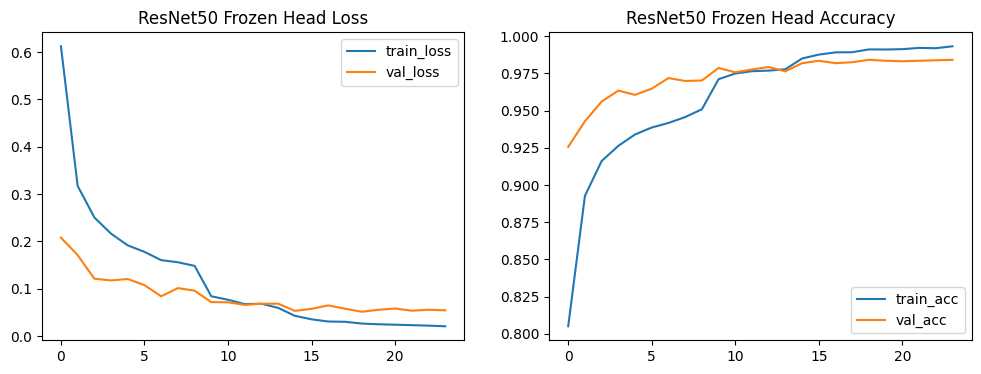

In [22]:

exp_id = "exp_resnet_frozen"
start = time.time()

def make_resnet_frozen(input_shape=(*IMG_SIZE,3), num_classes=num_classes, dropout=0.5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda t: tf.image.resize(t, IMG_SIZE))(inputs)
    x = resnet_preprocess(x)
    base = ResNet50(include_top=False, weights='imagenet', input_tensor=x, pooling='avg')
    base.trainable = False
    y = base.output
    y = layers.Dense(256, activation='relu')(y)
    y = layers.Dropout(dropout)(y)
    outputs = layers.Dense(num_classes, activation='softmax')(y)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_frozen = make_resnet_frozen()
history_resnet_frozen = resnet_frozen.fit(train_ds_p, validation_data=val_ds_p, epochs=30, callbacks=get_callbacks(3))
train_time = time.time()-start
val_loss, val_acc = resnet_frozen.evaluate(val_ds_p, verbose=0)
print(f"[{exp_id}] val_acc={val_acc:.4f}")

log_experiment({
    "exp_id": exp_id, "timestamp": datetime.utcnow().isoformat(),
    "approach":"deep","model":"ResNet50","variant":"frozen_head",
    "hyperparams": json.dumps({"lr":1e-3,"dropout":0.5}), "train_time_s": train_time,
    "val_acc": val_acc, "val_loss": val_loss, "notes":"Transfer learning with frozen base"
})

plot_history(history_resnet_frozen, "ResNet50 Frozen Head")


Evaluating Model...
Accuracy:  0.9842
Precision: 0.9843
Recall:    0.9842
F1-score:  0.9842

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.99      0.99       149
                     Pepper__bell___healthy       1.00      1.00      1.00       222
                      Potato___Early_blight       0.99      0.99      0.99       150
                       Potato___Late_blight       0.99      0.98      0.98       150
                           Potato___healthy       1.00      0.96      0.98        23
                      Tomato_Bacterial_spot       0.99      1.00      0.99       319
                        Tomato_Early_blight       0.95      0.93      0.94       150
                         Tomato_Late_blight       0.98      0.97      0.97       286
                           Tomato_Leaf_Mold       0.98      0.98      0.98       143
                  Tomato_Septori

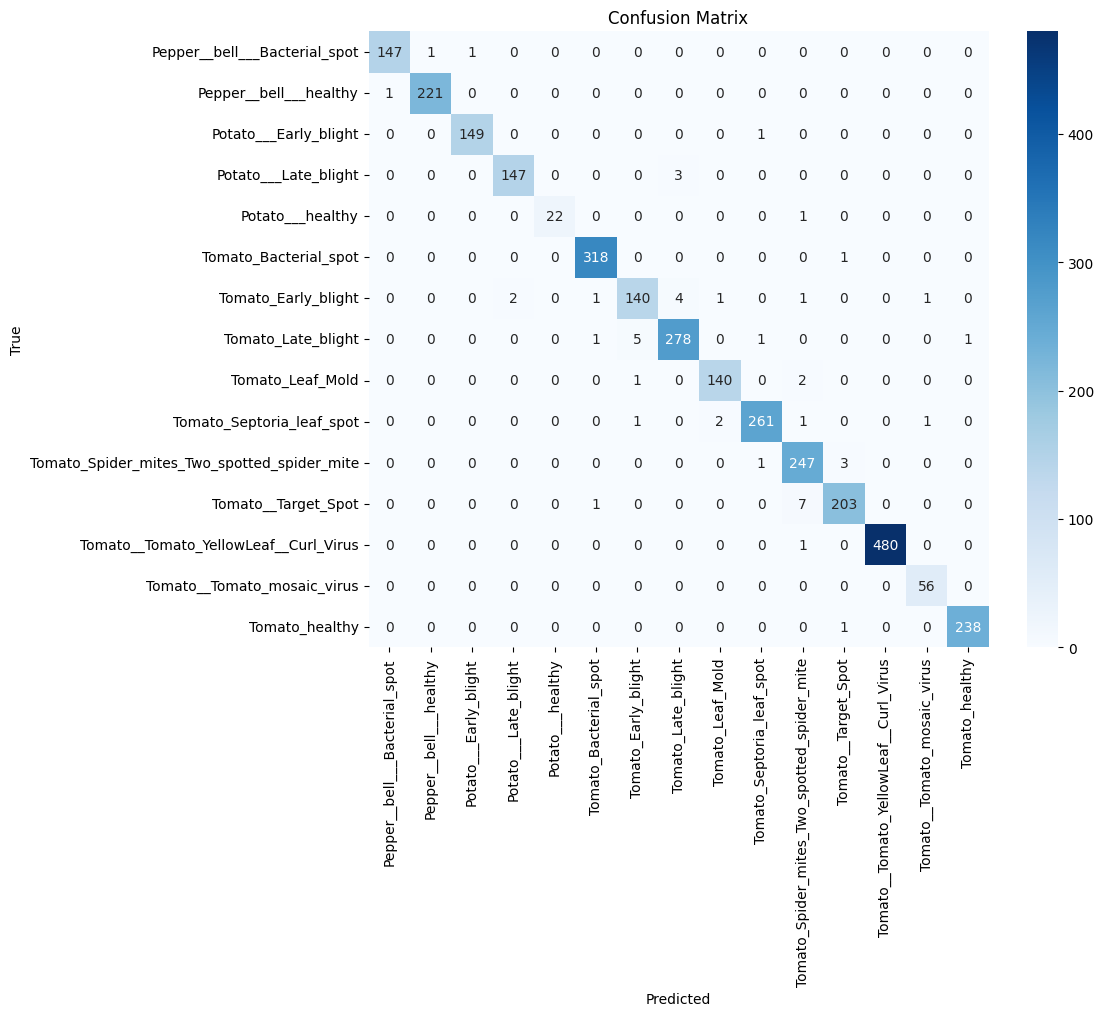

In [23]:
metrics_resnet = evaluate_model(resnet_frozen, val_ds_p, class_names, is_dl_model=True)